# Import libraries

In [4]:
from google.colab import drive
import os
from google.colab import files
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import torch
from pathlib import Path
import torch.nn.functional as F
from PIL import Image
import torchvision
import torch.nn as nn
import tensorflow as tf
import numpy as np
import torch.optim as optim
import pandas as pd
from torchvision.datasets import ImageFolder
import itertools
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix

# connect to google drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Uploade kaggle.json and download data to google drive

In [6]:
files.upload() 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d .
!rm chest-xray-pneumonia.zip
!ls

Saving kaggle.json to kaggle.json
kaggle.json
100% 2.29G/2.29G [00:30<00:00, 27.7MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.9MB/s]
chest_xray  gdrive  kaggle.json  sample_data


In [7]:
batch_size = 16
n_epochs = 30
image_size = 216
prob = 0.7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001

# prepare data for train
transform with probability on each image

In [8]:
class ImageDataset(object):
    def __init__(self, root, split, transforms=None):
        self.root = root
        self.transforms = transforms
        self.data_dir = os.path.join(root, split)
        self.images = []
        for i in list(sorted(os.listdir(os.path.join(self.data_dir, 'NORMAL')))):
            if i[-4:] == "jpeg":
                self.images.append((i, 'NORMAL'))
        for i  in list(sorted(os.listdir(os.path.join(self.data_dir, 'PNEUMONIA')))):
            if i[-4:] == "jpeg":
                self.images.append((i, 'PNEUMONIA')) 
     
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = os.path.join(self.data_dir, self.images[idx][1], self.images[idx][0])
        image = Image.open(path).convert('RGB').resize((image_size, image_size))
        image = np.moveaxis(np.array(image)/255.0, -1, 0)
        label = 0 if self.images[idx][1] == 'NORMAL' else 1
        if self.transforms is not None:
            image= self.transforms(torch.from_numpy(image).float())
        return image, label

# create train, test and valid datasets using the ImageDataset() class and three transforms

In [9]:
random_trans = transforms.RandomApply(torch.nn.ModuleList([transforms.RandomHorizontalFlip(p=prob),
                                                           transforms.RandomVerticalFlip(p=prob),
                                                           transforms.RandomPerspective(p=prob)]), p=0.5) 
train = ImageDataset("chest_xray/chest_xray", 'train',random_trans)
test = ImageDataset("chest_xray/chest_xray", 'test')
validation = ImageDataset("chest_xray/chest_xray", 'val')

# create dataloader of three datasets

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(validation, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle=False)

# Function for show images in dataset

In [11]:
def show(data):
    def plot(image):
        image, label = image
        image = transforms.ToPILImage()(image)
        plt.imshow(image)
        plt.title('normal' if label == 0 else 'pneumonia')

    fig = plt.figure(figsize=(40, 10))
    for i in range(1, 31):
        fig.add_subplot(3, 10, i)
        plot(data[random.randint(0, len(data) -1)])
    plt.show()

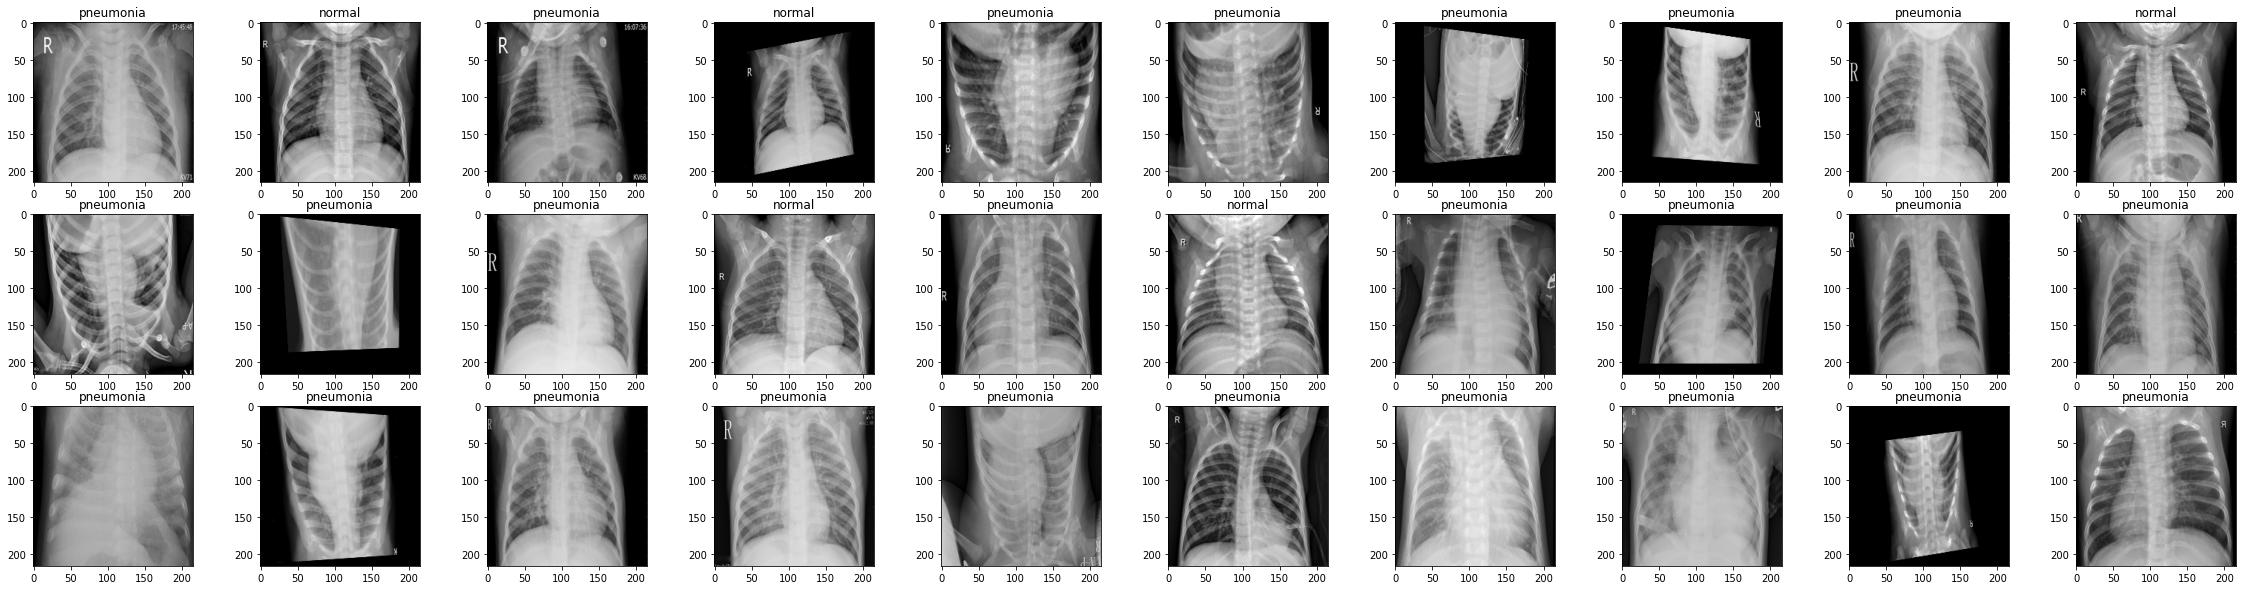

In [13]:
show(train)

# Creating a neural network
It has three residual block, each with two convolutional layers.
At first we have a residual class for blocks
that takes the size of the input,output,kernel and downsample then Makes two convolutional layers. In forward
We enter the input into this network and also implement skip-connection.Then on
We create a class of three residual blocks that size of
Their output is 16, 32 and 64, respectively,Inputs of this class are dropout and a list of paddings. Finally, we have a fully connected layer whose input size is obtained from the output size of the last residual block. The output size of this
Layer is 2 because we have two classes. In the make_layer function if the input and output sizes are not the same
Apply downsampling. Before passing to fc, be sure to use the fc's input shape in two dimensions using the view.


In [14]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, down_sample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=3, padding=0, bias=False)
        self.batch_n1 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=3, bias=False)
        self.batch_n2 = nn.BatchNorm2d(out_channels)

        self.soft = nn.Softmax(dim=1)
        self.down_sample = down_sample

    def forward(self, x):
        residual = x
        x = self.conv1(residual)
        x = self.batch_n1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_n2(x)
        if self.down_sample is not None:
            residual = self.down_sample(residual)
        x += x
        x = self.soft(x)
        return x

class ResNet(nn.Module):
    def __init__(self, paddings, dropout=True):
        super(ResNet, self).__init__()
        self.in_channels = 3
        self.dropout = dropout
        self.Dropout = nn.Dropout(0.4)

        down_sample = nn.Sequential(nn.Conv2d(3, 16, kernel_size=7, stride=3, padding=2), nn.BatchNorm2d(16))
        self.layer1 = self.make_layer(16, 7, paddings[0], down_sample)

        down_sample = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, stride=3, padding=1), nn.BatchNorm2d(32))
        self.layer2 = self.make_layer(32, 5, paddings[1], down_sample)

        down_sample = nn.Sequential(nn.Conv2d(32, 16, kernel_size=3, stride=3), nn.BatchNorm2d(16))
        self.layer3 = self.make_layer(64, 3, paddings[2], down_sample)

        self.fc = nn.Linear(9216, 2)
        
    def make_layer(self, out_channels, kernel_size, padding, down_sample):
        layers = []
        if self.in_channels != out_channels: 
            down_sample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size=kernel_size, stride=3, padding=padding, bias=False), nn.BatchNorm2d(out_channels))
        layers.append(ResBlock(self.in_channels, out_channels, kernel_size, down_sample))
        self.in_channels = out_channels
        return nn.Sequential(* layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        if self.dropout:
          x = self.Dropout(x)
        x = self.fc(x)
        return x

# Train the model
In each epoch, first the train data
We get batch of data put it to the model and calculate the loss, and use loss.backward () to Go back to the beginning of the network and update the optimizer.print loss in every epoch. In every 5 epochs we display the loss value on the valid data and plot the train loss change diagram. In all 4 epochs using the update_lr function
to update the value of learning_rate if the value of the loss on the data was less valid We update min_valid_loss and save the model.

In [16]:
def learning_rate_update(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
def train(model):
    lr = learning_rate
    min_valid_loss = np.inf
    train_losses = []
    validation_losses = []
    eps = []
    for epoch in range(n_epochs):
        eps.append(epoch+1)
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = F.one_hot(labels, 2)
            optimizer.zero_grad()
            outputs = model(images.float())
            labels = labels.type_as(outputs)
            loss = F.binary_cross_entropy_with_logits(outputs, labels)    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_losses.append(train_loss/len(train_loader))
        print(f'Epoch {epoch+1} \t\t Train Loss: {\
            train_loss / len(train_loader.sampler)}')
        valid_loss = 0.0
        model.eval()
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = F.one_hot(labels, 2)
            outputs = model(images.float())
            labels = labels.type_as(outputs)
            loss = F.binary_cross_entropy_with_logits(outputs, labels)
            valid_loss += loss.item() * images.size(0)
        validation_losses.append(valid_loss/len(val_loader))

        if (epoch + 1) % 5 == 0:
           print(f'Epoch {epoch+1} \t\t Validation Loss: {\
             valid_loss / len(val_loader)}')

        if (epoch + 1) % 4 == 0:
            lr = lr / 3.
            learning_rate_update(optimizer, lr)
      
        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_model.pth')
    plt.plot(eps, train_losses)
    plt.title("train loss")
    plt.xlabel("num of epoch")
    plt.ylabel("loss")
    plt.show()

# accuracy
Here we load the saved model and test it on the test data
 and print the values ​​of accuracy

In [17]:
def accuracy(model):
    model.to("cuda")
    model.load_state_dict(torch.load("saved_model.pth"))
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        total = 0.0
        correct = 0.0
        predictions = []
        ll = []
        for data in test_loader:
            images, labels = data
            y_hot = F.one_hot(labels, 2)
            images, y_hot = images.to(device), y_hot.to(device)
            outputs = model(images.float())
            y_hot = y_hot.type_as(outputs)
            _, preds = torch.max(outputs, 1)
            for k in preds.cpu().numpy():
               predictions.append(k)
            for k in labels.cpu().numpy():
                ll.append(k)
            total += labels.size(0)
            correct += (labels.to("cuda") == preds).sum().item()
            loss =  F.binary_cross_entropy_with_logits(outputs, y_hot)
            test_loss += loss.item() * images.size(0)
    print("Accuracy on test data: " + str(correct/total))

# model with dropout

In [18]:
model = ResNet([2, 1, 0], dropout=True)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Epoch 1 		 Train Loss: 0.31985820091666617
Epoch 2 		 Train Loss: 0.5916062196705238
Epoch 3 		 Train Loss: 0.5751709522096657
Epoch 4 		 Train Loss: 0.5743535040803482
Epoch 5 		 Train Loss: 0.5727826513212882
Epoch 5 		 Validation Loss: 13.09870719909668
Epoch 6 		 Train Loss: 0.5721354368457033
Epoch 7 		 Train Loss: 0.5709576188055284
Epoch 8 		 Train Loss: 0.5721996266600544
Epoch 9 		 Train Loss: 0.5706579680640274
Epoch 10 		 Train Loss: 0.5703719695287248
Epoch 10 		 Validation Loss: 13.167686462402344
Epoch 11 		 Train Loss: 0.570062485757781
Epoch 12 		 Train Loss: 0.570556458154339
Epoch 13 		 Train Loss: 0.5702613875544145
Epoch 14 		 Train Loss: 0.5701877169448174
Epoch 15 		 Train Loss: 0.569986216769628
Epoch 15 		 Validation Loss: 13.488765716552734
Epoch 16 		 Train Loss: 0.5702720549574659
Epoch 17 		 Train Loss: 0.5700530994889195
Epoch 18 		 Train Loss: 0.5701011889185642
Epoch 19 		 Train Loss: 0.5700830996402202
Epoch 20 		 Train Loss: 0.5700345393155981
Epoch 20 

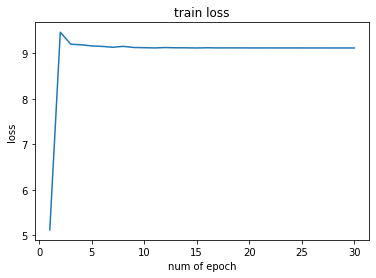

In [19]:
train(model)

In [20]:
accuracy(model)

Accuracy on test data: 0.625


# model without dropout

In [21]:
model = ResNet([2, 1, 0], dropout=False)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Epoch 1 		 Train Loss: 0.29870580303614125
Epoch 2 		 Train Loss: 0.5531005491873969
Epoch 3 		 Train Loss: 0.39297046398092633
Epoch 4 		 Train Loss: 0.3500970385831558
Epoch 5 		 Train Loss: 0.30596839517720636
Epoch 5 		 Validation Loss: 14.970170974731445
Epoch 6 		 Train Loss: 0.27427764223214307
Epoch 7 		 Train Loss: 0.2766252209780955
Epoch 8 		 Train Loss: 0.25305904861699585
Epoch 9 		 Train Loss: 0.24387840675247227
Epoch 10 		 Train Loss: 0.2476529597984684
Epoch 10 		 Validation Loss: 22.126220703125
Epoch 11 		 Train Loss: 0.2410429993450093
Epoch 12 		 Train Loss: 0.23612989641817436
Epoch 13 		 Train Loss: 0.2303852014974948
Epoch 14 		 Train Loss: 0.2274814302250286
Epoch 15 		 Train Loss: 0.22900408994337898
Epoch 15 		 Validation Loss: 19.246015548706055
Epoch 16 		 Train Loss: 0.2239536101261348
Epoch 17 		 Train Loss: 0.21434441877334762
Epoch 18 		 Train Loss: 0.22310520062348776
Epoch 19 		 Train Loss: 0.22293048438278992
Epoch 20 		 Train Loss: 0.229774519783998

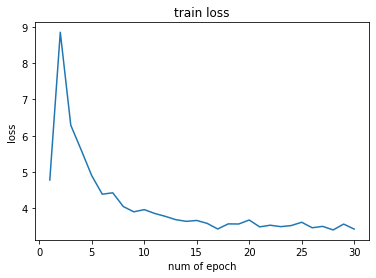

In [22]:
train(model)

In [23]:
accuracy(model)

Accuracy on test data: 0.7323717948717948
